# Weather Monitoring in the UK

## Part 1 - Data Collection, Pre-processing and Handling

<b>Please Note:</b> Requires Pandas v2.1.4

For data, we will be scraping the MET Office's website for the weather reporting of each individual major weather station across the UK. However, not every station will be of use based on operational years and missing data. We will need to clean out the additional markers put in place by the stations, remove unneeded information, and reformat everything to begin analysis and comparison. Since the files will be imported as .txt files, there needs to be extra care in handling headers and broken data. Additional steps were taken as explained in the comments and doc-strings below.

Besides running this notebook, no additional steps are needed by users as all data is scraped and handled by the program itself.

### Loading the Data

In [1]:
# Import everything needed for this assignment here
import urllib.request as urllib
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm_notebook
from matplotlib.ticker import MaxNLocator

In [2]:
# Prepare webpage scrapping
html = urllib.urlopen("https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data")
contents = html.read()
soup = BeautifulSoup(contents)

def accessWeatherData(link):
    """
    Accesses txt file of station weather data and converts to a dataframe
 
    Params:
        link (str): the url for the station's weather data.
 
    Returns:
        DataFrame: the weather data converted to a dataframe with 7 attributes
    """
    # Dropping extra Provisional Column as this will not be used for later analysis
    tempDataFrame = pd.read_csv(link, sep="\s+", usecols=[i for i in range(7)], header=None, names=["Year", "Month", "TempMax", "TempMin","AirFrost","Rain","SunshineHours"])
    return tempDataFrame.iloc[(tempDataFrame.loc[tempDataFrame['Year']=='yyyy'].index[0]+2):, :].reset_index(drop = True)

# Pull out relevant links from webpage
links = soup.find_all('a', {'href': re.compile('/stationdata/')})

# Data Structure
# weatherData = [{'name': 'station_name, 'data': 'weather_data'}, ...]
weatherData = []
weatherDict = {} # set this up for experimentation

# Load in all data sets
for link in tqdm_notebook(links, desc = 'Loading Weather Data Sets'):
    name = re.findall(r'stationdata/(.*?)data.txt', link['href'])[0]
    # print('Loading...', name, '\t\t\t', end='\r')
    data = accessWeatherData(link['href'])
    weatherData.append({'name': name, 'data': data})
    weatherDict[name] = data

# print('Loading Datasets Complete')


Loading Weather Data Sets:   0%|          | 0/37 [00:00<?, ?it/s]

### Cleaning the Data

In [3]:
# Resets var for cleaning data for effective testing
cleaningWeatherData = []
for x in weatherData:
    cleaningWeatherData.append({'name': x['name'], 'data': x['data'].copy(deep=True)})

# Code for cleaning the data begins here:
def cleanData(stationData): 
    """
    Cleans the dataframes to avoid unexpected characters, blankspaces, and typing
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data cleaned
    """
    # Prep the data
    workingData = prepForCleaning(stationData)

    # Remove alpha characters from columns
    workingData = removeAlphaCharacters(workingData)

    # Handle Blanks
    workingData = handleBlanks(workingData)
    
    # Handle the Sunshine Hours Data
    workingData = handleSunshineData(workingData)

    # Handle the *'s that indicate estimation
    workingData = handleEstimations(workingData)

    # Convert numbers to ints or floats respectively
    workingData = handleTypes(workingData)
    
    return workingData

def prepForCleaning(data):
    """
    Remove excess rows pertaining to site closures
 
    Params:
        data (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data without excess rows
    """
    filter = data['Year'].str.contains(r'\D')
    return data[~filter]

def handleSunshineData(stationData):
    """
    Creates new column to store if sunshine data was taken with Kipp & Zonen sensor or Campbell Stoke recorder
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data with a new column for tracking sunshine recording methodologies
    """
    workingData = stationData.assign(SunshineRecorder='Campell Stokes') 
    for i, row in workingData.iterrows():
        if type(row['SunshineHours']) == str and '#' in row['SunshineHours']:
            workingData.loc[i,'SunshineRecorder'] = 'Kipp & Zonen'
            workingData.loc[i,'SunshineHours'] = row['SunshineHours'].replace('#','')
    return workingData

def handleEstimations(stationData):
    """
    Remove *'s that indicate estimation
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data cleaned of estimation markings
    """
    return stationData.replace("[*, $]", "", regex=True)

def removeAlphaCharacters(stationData):
    """
    Remove alpha characters from numeric data
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data cleaned of alpha characters
    """
    return stationData.replace('[a-zA-Z]', "", regex=True)

def handleBlanks(stationData):
    """
    Replace blanks/NaN with -10000.
    Further explanation: -27.2C is the lowest recorded temperature in the UK. Anything lower would not be feasible. 
    Also any negative numbers for AirFrost, Rain, or Sunshine hours would not be feasible.
    This will allow us to cast the columns to the correct types for future calculations.
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data cleaned of blanks
    """
    return stationData.replace(['---', 'NaN'], '-10000', regex=True)

def handleTypes(stationData):
    """
    Cast columns to correct typing
 
    Params:
        stationData (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data casted to correct typings
    """
    conversions = {'Year': int, 'Month': int, 'TempMax': float, 'TempMin': float, 'AirFrost': int, 'Rain': float, 'SunshineHours': float}
    return stationData.astype(conversions)    

# Go through Stations and clean each dataset.
for i, station in enumerate(tqdm_notebook(cleaningWeatherData, desc="Cleaning Data")):
    cleaningWeatherData[i]['data'] = cleanData(station['data'])




Cleaning Data:   0%|          | 0/37 [00:00<?, ?it/s]

## Part 2: Average Temperature Change

#### Before choosing a time period to analyze, let's look at all the stations over the course of the past 120 years
Due to the number of stations invovled, the following graph will first appear very messy and concentrated. However using plotly and seaborn, the graph is made interactive to choose which station to take a look at. Showing all the stations helps highlight why some stations are removed from further formulation and consideration. This graph gives the big overview of weather in the UK as we move into more purposeful and restricted analysis later on.

Building Graphs:   0%|          | 0/37 [00:00<?, ?it/s]

This interactive graph that shows the annual average temperature for each station from 1900-2023
Click on stations in the legend to hide their line graph.


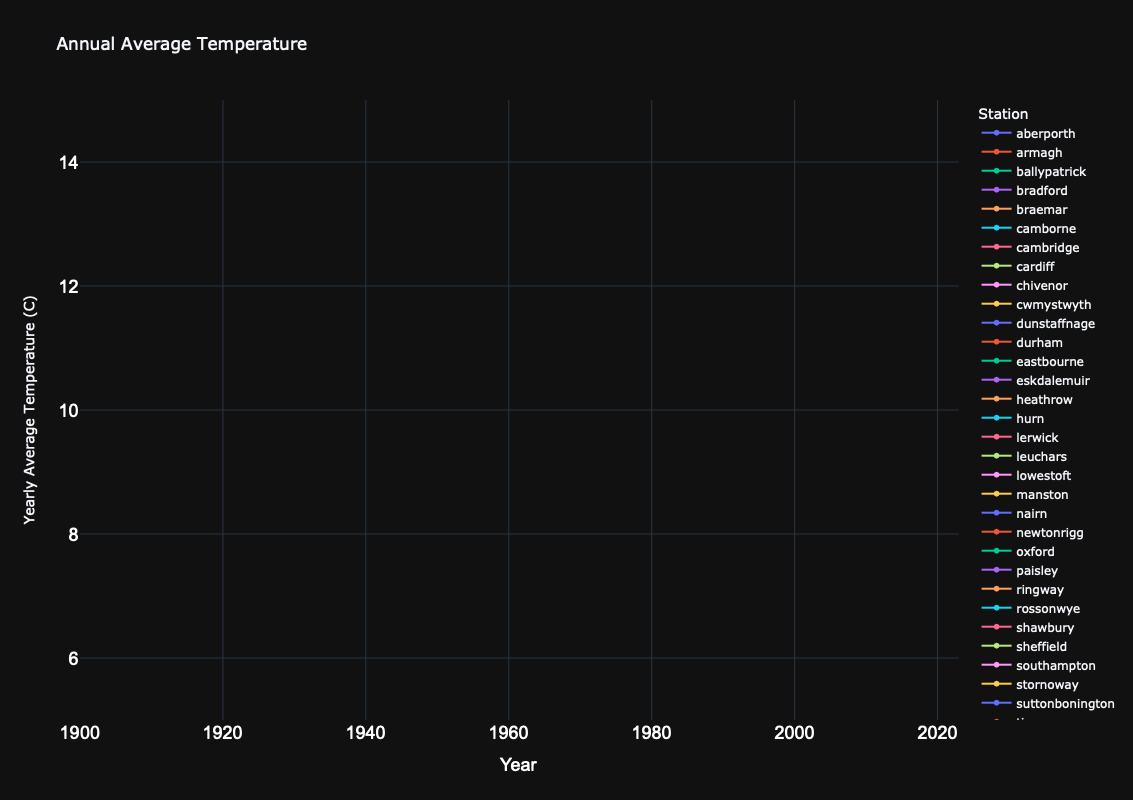

In [4]:
def calcMonthlyAvgTemp(data):
    """
    Calculates the average monthly temperatures
 
    Params:
        data (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: the weather data with calculated monthly temperature averages
    """
    calcData = data.loc[:, ['Year', 'Month','TempMax','TempMin']]
    calcData = calcData.assign(MonthAvgTemp=float('-1000'))
    for i, row in calcData.iterrows():
        if row['TempMax'] > -100.0 and row['TempMin'] > -100.0:
            calcData.loc[i,'MonthAvgTemp'] = (float(row['TempMax']) + float(row['TempMin']))/2
    return calcData

def calcYearlyAvgTemp(data):
    """
    Calculates the average yearly temperatures
 
    Params:
        data (DataFrame): the weather data in a DataFrame with monthly averages.
 
    Returns:
        DataFrame: the weather data with calculated yearly temperature averages
    """
    groupedYear = data.loc[:, ['Year','MonthAvgTemp']].groupby('Year', as_index=False)
    return groupedYear.mean().rename(columns={'MonthAvgTemp':'YearlyAvgTemp'})

avgTempGraphingData = pd.DataFrame()

# Calculate for each station
for i, station in enumerate(tqdm_notebook(cleaningWeatherData, desc="Building Graphs")):
    monthlyTemps = calcMonthlyAvgTemp(station['data'])
    yearlyTemp = calcYearlyAvgTemp(monthlyTemps)
    finalSet = yearlyTemp.loc[yearlyTemp['YearlyAvgTemp'] >= -15.0]
    finalSet = finalSet.assign(Station=station['name'])
    avgTempGraphingData = pd.concat([avgTempGraphingData, finalSet], axis=0, sort=True)

# Graph the Average Annual Temperatures
annualAvgTempFig = px.line(
    avgTempGraphingData,
    x=avgTempGraphingData['Year'],
    y="YearlyAvgTemp", 
    title='Annual Average Temperature', 
    template="plotly_dark",
    color=avgTempGraphingData['Station'],
    height=800)

annualAvgTempFig.update_traces(mode="lines+markers")

# Modify axis label properties
annualAvgTempFig.update_xaxes(range=[1900, 2023], 
                    title_font={"size":18, "family": "Arial", "color":"white"}, 
                    tickfont={"size":18, "family": "Arial", "color":"white"})

annualAvgTempFig.update_yaxes(range=[5, 15],
                    title_font={"size":18, "family": "Arial", "color":"white"}, 
                    tickfont={"size":18, "family": "Arial", "color":"white"},
                   title='Yearly Average Temperature (C)')

# Include additional information in the console
print('This interactive graph that shows the annual average temperature for each station from 1900-2023')
print('Click on stations in the legend to hide their line graph.')
annualAvgTempFig.show()

Data provided by https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

### Let's shift our focus to the period of 1987 to 2023
Although some stations have been recording data since the mid-1800s, we want to compare all stations available to us. Thus we will start from the point when all stations were consistently recording.

*Do note that Cwmystwyth, Ringway, and Southampton all closed their sites in the early 2000's, so they will not be using them for these comparisons.

Calculating Percentages:   0%|          | 0/37 [00:00<?, ?it/s]

Temperature Change Stats:
	Eskdalemuir had the biggest increase in temperature at 30.366%
	Lerwick had the smallest change in temperature overall with 13.077%




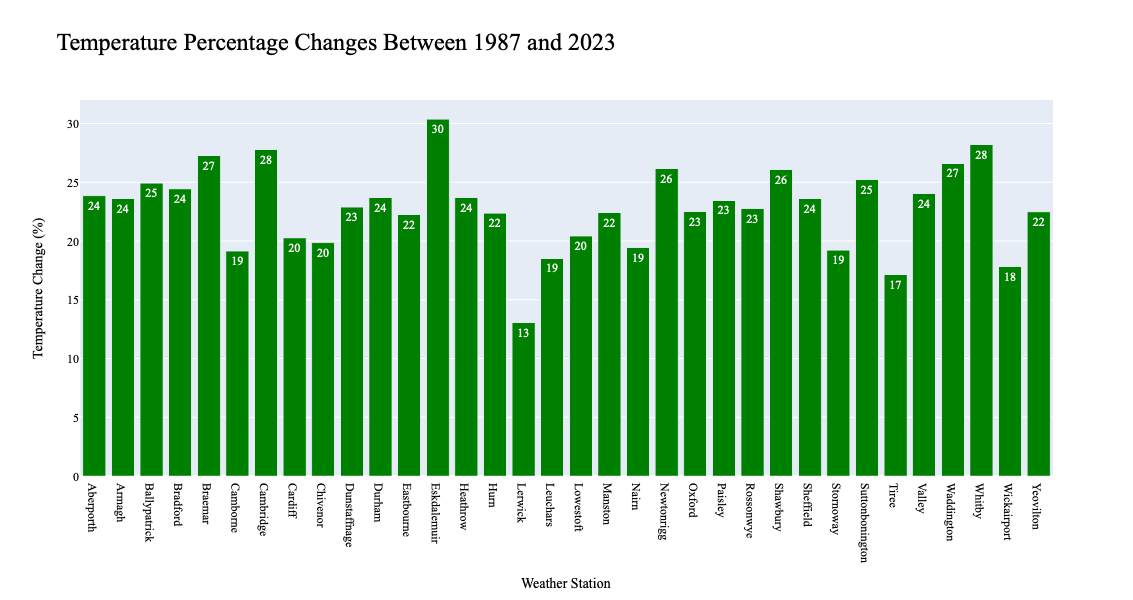

In [9]:
percentages = pd.DataFrame(columns=['Station','TempChange'])

# Calculate across each station excluding those that have been shut down before 2023
for i, station in enumerate(tqdm_notebook(cleaningWeatherData, desc="Calculating Percentages")):
    if station['name'] in ['cwmystwyth','ringway', 'southampton']:
        continue

    # Temperature average calculations using previous functions
    monthlyTemps = calcMonthlyAvgTemp(station['data'])
    yearlyTemp = calcYearlyAvgTemp(monthlyTemps)

    # Restricting the period of time
    subsetYears = yearlyTemp.loc[(yearlyTemp['Year'] >= 1987) & (yearlyTemp['Year'] <= 2023)]  
    
    yearEnd = float(subsetYears.iloc[-1]['YearlyAvgTemp'])
    yearStart = float(subsetYears.loc[subsetYears['Year'] == 1987]['YearlyAvgTemp'].iloc[0])

    # Calculating percentages for the next graph
    percentage = ((yearEnd - yearStart) / yearStart) * 100.0

    percentages.loc[len(percentages)] = {'Station': station['name'].capitalize(), 'TempChange': percentage}


# Get the values needed for biggest increase, biggest decrease, and smallest change
absValueTemps = percentages.copy(deep=True)
absValueTemps['TempChange'] = absValueTemps['TempChange'].abs()

biggestIncreaseChangeIndex = percentages['TempChange'].idxmax()
smallestChangeOverallIndex = absValueTemps['TempChange'].idxmin()

# Print temperature change information in the console
print("Temperature Change Stats:")
print(f"\t{percentages.iloc[biggestIncreaseChangeIndex]['Station'].capitalize()} had the biggest increase in temperature at {np.round(percentages.iloc[biggestIncreaseChangeIndex]['TempChange'],3)}%")
print(f"\t{percentages.iloc[smallestChangeOverallIndex]['Station'].capitalize()} had the smallest change in temperature overall with {np.round(percentages.iloc[smallestChangeOverallIndex]['TempChange'],3)}%")
print('\n')

# Code for graphing
tempChangeFig = px.bar(percentages, 
             y="TempChange", 
             x="Station", 
             title="Temperature Percentage Changes Between 1987 and 2023",
             height=600,
             range_y=[0,32],
             text_auto='.2s',
            )

tempChangeFig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    title_font_size=24,
    xaxis_title="Weather Station",
    yaxis_title="Temperature Change (%)",
)

tempChangeFig.update_traces(marker_color='green')

tempChangeFig.show()



Data provided by https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

### Is this graph an effective representation of temperature change?

This graph clearly would depict Southampton and Cwmystwyth stations having dramatic decreases in temperature between 1987 and their closure if included.
- If we had included the two closed stations, this decrease would have been due to incomplete yearly data. The final year of each closed station is not complete thus skewing towards winter months and thus cooler temperatures unlike the previous annual accounts.

We must consider the accurate representation with the points of comparison given this being a direct comparison of 1987 to 2023
- To explain further, this graph depicts the relationship between only two years. To get a better idea of temperature change, a line of regression could be introduced for all years average temperature for each station. Instead of comparing the percentages of the most recent year to starting point, we'd instead be looking at the magnitude of the slope. We would have better insight into each year has compared to each other.
- By just using the two years and comparing this often significant increase, we are able to highlight just how dramatric the impact of climate change really has become. A signficant portion of the world's population has lived through this recording period and thus have inexplicably experience this temperature change.

## Part 3: Station Rankings

#### Now let's look at the highest temperatures for each station
For this visualization, the data will be presented in a box plot per station. Each station's maximum yearly temperature will form the basis for the variance and the general central tendancy from 1987 to 2023. The highest point of each arm denotes the maximum temperature found for each station.

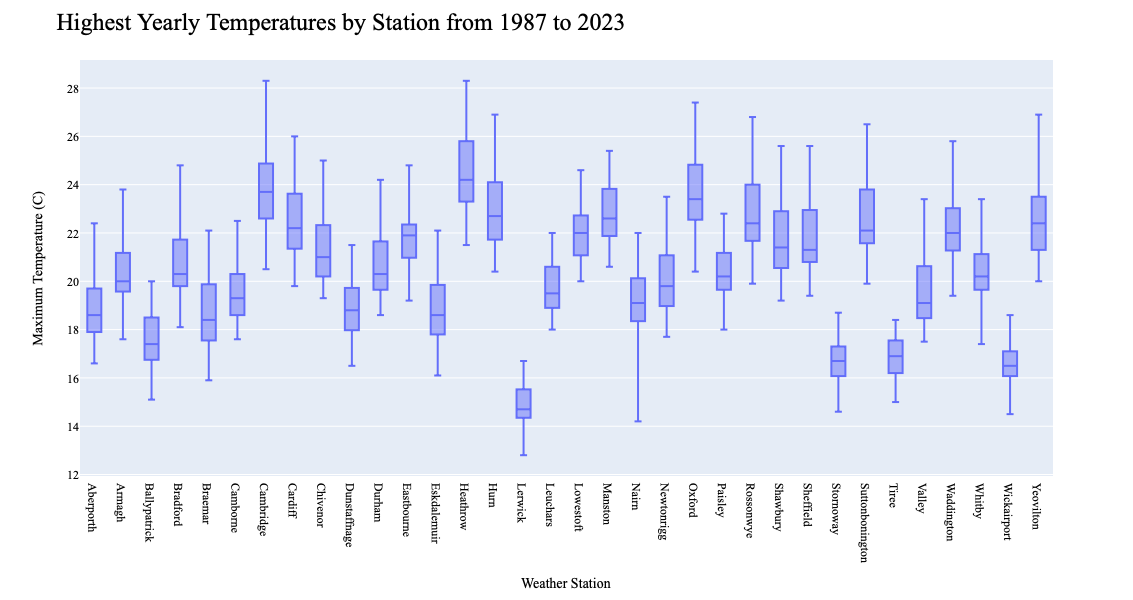



 The Top 10 Stations by Highest Recorded Temperatures Since Opening 

           Station  Year  MaxTemp
0        Cambridge  2006     28.3
1         Heathrow  2018     28.3
2           Oxford  2018     27.4
3        Yeovilton  1995     26.9
4             Hurn  1995     26.9
5        Rossonwye  2006     26.8
6  Suttonbonington  2006     26.5
7       Waddington  1947     26.1
8          Cardiff  1995     26.0
9        Sheffield  2006     25.6


In [6]:
def calcHighestTempPerYear(data):
    """
    Calculates the highest temperature per year per station
 
    Params:
        data (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: a dataframe of the highest temperature per year
    """
    groupedYear = data.loc[:, ['Year','TempMax']].groupby('Year', as_index=False).max()
    cleanedGroupedYear = groupedYear.loc[(groupedYear['Year'] >= 1987) & (groupedYear['Year'] <= 2023) & (groupedYear['TempMax'] > -50)]
    return cleanedGroupedYear

# Set up dataframe
singleHighestTemp = pd.DataFrame(columns=['Station','Year','MaxTemp'])

# Calculate highest temperature per station overall
for i, station in enumerate(cleaningWeatherData):
    if station['name'] in ['cwmystwyth','ringway', 'southampton']:
        continue
    
    momentOfMaxTemp = station['data'].iloc[station['data']['TempMax'].idxmax()]
    singleHighestTemp.loc[len(singleHighestTemp)] = {
        'Station': station['name'].capitalize(),
        'Year': momentOfMaxTemp['Year'],
        'MaxTemp': momentOfMaxTemp['TempMax']
    }

# Set up dataframe for graphing
boxplotGraph = pd.DataFrame()

# Calculate the highest temperature per year per station
for i, station in enumerate(cleaningWeatherData):
    if station['name'] in ['cwmystwyth','ringway', 'southampton']:
        continue

    calcData = calcHighestTempPerYear(station['data']).rename(columns={"TempMax": "MaxTemp"}).assign(Station=station['name'].capitalize()).loc[:,['Station','Year','MaxTemp']]

    boxplotGraph = pd.concat([boxplotGraph, calcData], axis=0, sort=True)

# Plot box plot
highTempGraph = px.box(boxplotGraph, x="Station", y="MaxTemp")
highTempGraph.update_layout(
    title="Highest Yearly Temperatures by Station from 1987 to 2023",
    height=600,
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="black",
    title_font_size=24,
    xaxis_title="Weather Station",
    yaxis_title="Maximum Temperature (C)",
)

# Get rid of outlier points
highTempGraph.update_traces(boxpoints=False)

highTempGraph.show()

# Include the top 10 stations with the highest recorded temperatures overall
print('\n\n','The Top 10 Stations by Highest Recorded Temperatures Since Opening','\n')
singleHighestTemp = singleHighestTemp.sort_values(by='MaxTemp', ascending=False).reset_index(drop=True)
print(singleHighestTemp.head(10))


Data provided by https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

### Higher Temperatures All Around

In this graph, we see a visualization of how the maximum yearly temperature varies between 1987 and 2023 for each station. At the top of each individual box plot is the maximum temperature recorded at that station. The longer the box plot the larger the overall variation has been for that station across this 36 years.

This data is as expected with many of the stations with overall lower maximum annually recorded temperatures are from stations farther north meanwhile many of the stations with overall higher maximum annually recorded temperatures are from stations farther south.

When we look at the final printed table, which takes into account all stations across their entire operational period, the highest temp for the Waddington station was taken in 1947. Since this was the same year the station became operationally functionally, this may be a recording error. If accurate, this breaks the trend of the other stations which were found to have higher temperatures recorded in the last 30 years. 

## Part 4: Surprising Results

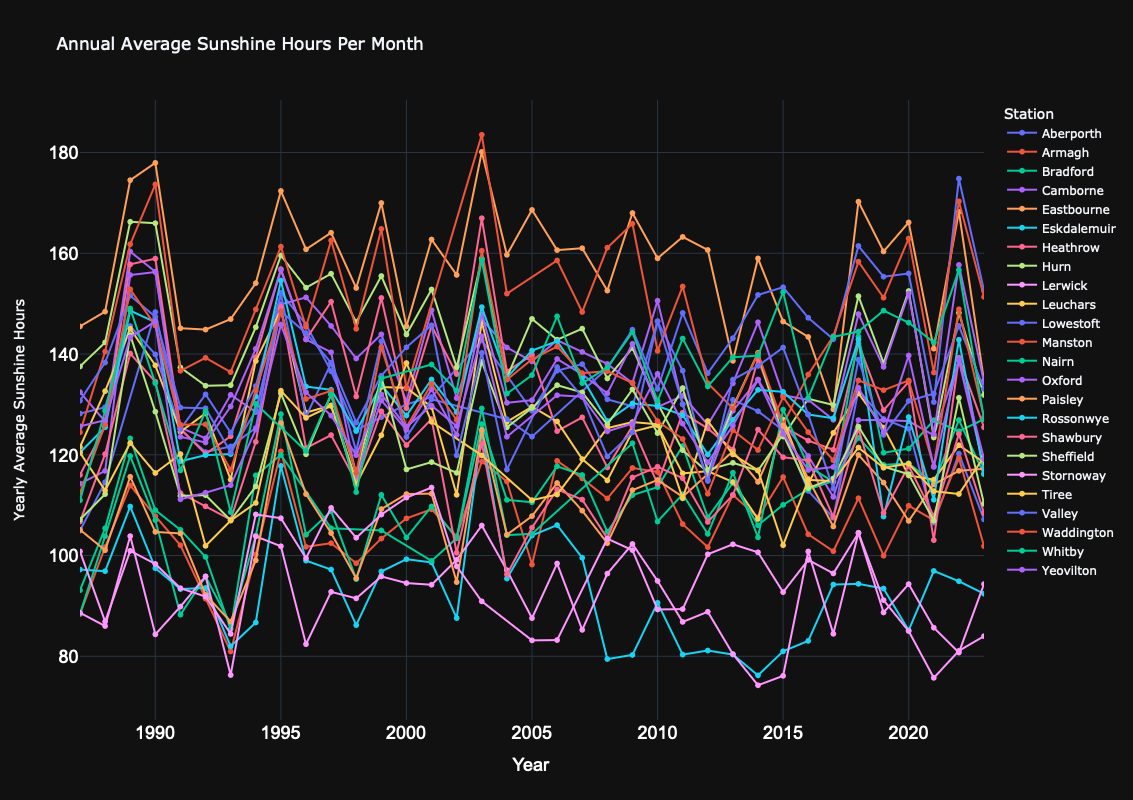

In [7]:
def calcYearlyAvgSunHours(data):
    """
    Calculates the average sun hours per year
 
    Params:
        data (DataFrame): the weather data in a DataFrame.
 
    Returns:
        DataFrame: a dataframe of the average sun hours per station per year
    """
    groupedYear = data.loc[:, ['Year','SunshineHours']].groupby('Year', as_index=False).mean().rename(columns={'SunshineHours':'YearlyAvgSunshineHours'})
    cleanedGroupedYear = groupedYear.loc[(groupedYear['Year'] >= 1987) & (groupedYear['Year'] <= 2023) & (groupedYear['YearlyAvgSunshineHours'] > 0)]
    return cleanedGroupedYear
    
# Set up dataframe for the graph
sunshineGraph = pd.DataFrame()

for i, station in enumerate(cleaningWeatherData):
    # Skip all the stations with noted insufficient sunshine data
    if station['name'] in ['cwmystwyth','ringway', 'southampton', 'ballypatrick', 'braemar','cambridge','cardiff', 'dunstaffnage', 'durham','suttonbonington','wickairport']:
        continue

    calcData = calcYearlyAvgSunHours(station['data']).assign(Station=station['name'].capitalize()).loc[:,['Station','Year','YearlyAvgSunshineHours']]
    
    sunshineGraph = pd.concat([sunshineGraph, calcData], axis=0, sort=True)

# Plot the sunshine hours
sunshineAvgFig = px.line(sunshineGraph,
                         x=sunshineGraph['Year'],
                         y="YearlyAvgSunshineHours", 
                         title='Annual Average Sunshine Hours Per Month', 
                         template="plotly_dark",
                         color=sunshineGraph['Station'],
                         range_x=[1987,2023],
                         height=800)

sunshineAvgFig.update_traces(mode="lines+markers")

# Modify axis label properties
sunshineAvgFig.update_xaxes(
    title_font={"size":18, "family": "Arial", "color":"white"}, 
    tickfont={"size":18, "family": "Arial", "color":"white"})

sunshineAvgFig.update_yaxes(
    title_font={"size":18, "family": "Arial", "color":"white"}, 
    tickfont={"size":18, "family": "Arial", "color":"white"},
    title='Yearly Average Sunshine Hours')

sunshineAvgFig.show()


Data provided by https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

## Surprising Sushine
For this portion of the assignment, I decided to take a look at the sunshine hours recorded by the majority of the stations in the UK. Unforuntately, 11 of the stations either were closed or did not record enough sunshine data to be a part of this visualization.

The first thing I find surprisng about this is how often the different stations follow the same trends. Given that the UK is approximately 1000km from top to bottom and about 500km across, the cloud coverage and weather can vary across the land. If weather varies enough, for example if Scotland recieved more rain than Wales, it would explain deviations where one trend goes up but another goes down. However from 2002 to 2003 most stations saw a spike in sunshine hours typically around 20-35 hours difference.

### In the Face of Climate Change
Due to climate change, weather patterns and UV penetration are changing. With a shift in weather patterns over the past 40 years, there can be an unexpected variance in these sunshine hours. Warming oceans leading to higher levels of moisture in the atmospher and thus more rain will impact the amount of cloud coverage over the UK. At the same time, pollution in the atmosphere has changed the ability for UV radiation to penetrate down to Earth. Since the main monitoring systems use UV to detect sunshine hours, this may also impact the actual sunshine hours of each month across each year. 

### Noteworthy Details
- In the mid 2000's many stations switched from a Campbell-Stokes recording system to the Kipp and Zonen sensor which could impact the outcomes.

# Part 5: Other Sources

After analyzing the UK's various stations and their reporting, we must pull back and compare the UK as a whole to the rest of the world. Data will be pulled from NASA GISS analysis to compare the changing tempatures across the UK to the global Land-Sea temperatures.

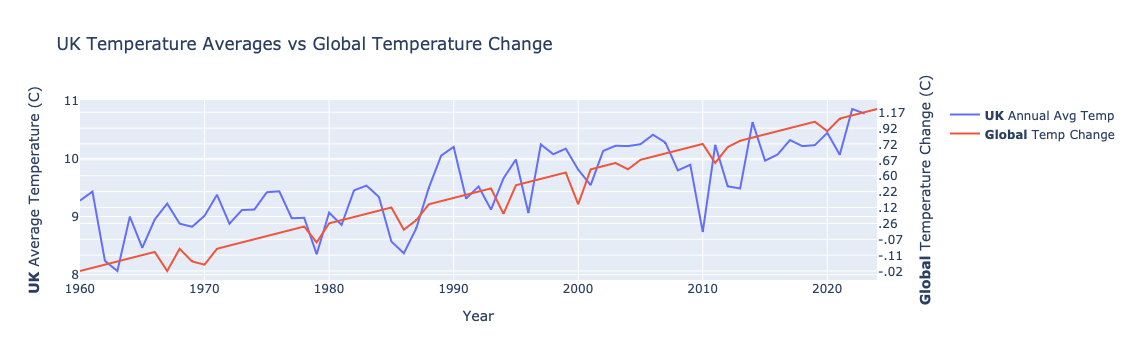

In [8]:
# Retrieve Global Data
globalData = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv", header=1)
globalGraphingData = globalData.loc[:,['Year','J-D']].reset_index(drop=True).rename(columns={'J-D':'YearlyChange'})
globalGraphingData = globalGraphingData.loc[(globalGraphingData['Year'] >= 1960)]

# Evaluate UK Annual Average Temperatures
stationAnnualTemps = avgTempGraphingData.copy(deep=True)
stationAnnualTemps.drop(columns=['Station'])
groupedUKAverages = stationAnnualTemps.loc[:,['Year','YearlyAvgTemp']].groupby('Year', as_index=False).mean()
groupedUKAverages = groupedUKAverages.loc[(groupedUKAverages['Year'] < 2024) & (groupedUKAverages['Year'] >= 1960)]

# Create dual y-axis plot
globalAveragePlot = make_subplots(specs=[[{"secondary_y": True}]])

# Add each dataset
globalAveragePlot.add_trace(
    go.Scatter(x=groupedUKAverages['Year'], y=groupedUKAverages['YearlyAvgTemp'], name="<b>UK</b> Annual Avg Temp"),
    secondary_y=False,
)

globalAveragePlot.add_trace(
    go.Scatter(x=globalGraphingData['Year'], y=globalGraphingData['YearlyChange'], name="<b>Global</b> Temp Change"),
    secondary_y=True,
)

# Add additional information
globalAveragePlot.update_layout(
    title_text="UK Temperature Averages vs Global Temperature Change",
)

globalAveragePlot.update_xaxes(title_text="Year")

globalAveragePlot.update_yaxes(title_text="<b>UK</b> Average Temperature (C)", secondary_y=False)
globalAveragePlot.update_yaxes(title_text="<b>Global</b> Temperature Change (C)", secondary_y=True)

globalAveragePlot.show()


Data provided by https://data.giss.nasa.gov/gistemp/ and https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

### The Graph
This visualization utilizes a dual-y-axis system to compare two datasets using related but different parameters. 
- On the left: The temperature in celusius for the UK based on the averaging of the annual recordings of operational stations
- On the right: The year-over-year temperature change in celsius for the global averages of land-sea surface temperatures

Thus we are able to compare the analysis we previously did on the UK for the annual average temperature with that of the year-over-year temperature changes. It is worth noting that while this methodology allows for this visual comparison, the anlaysis must not completely rely on the visual aspect seeing as the data could be skewed without further statiscal formulation.

### The World Is Getting Hotter
With years of ongoing discussion of climate change and global warming, it should come as little surprise that both the UK and the rest of the world are on an upward trend in temperature. It follows logic that the UK temperature averages would follow a similar increasing course as the rest of the world considering the global temperature change data contains averages for all land-sea zones currently being recorded. Temperature is rising both on the scale of a country and on the scale of the globe.

In this case, the temperature is increasing at about 0.05C per year and shows no signs of slowing down. Without measures to counteract this upward trending line, the global temperature will continue to rise and have a visceral impact on everything from ecosystems, natural resources, water levels, and more. 

We've seen the world work together to fix the hole in the ozone layer. This data suggest that similar measures must be taken, on the global stage, to fight the increasing temperatures before the damage is irreperable. I may escape the wrath of the growing warmth, but at the very least my future children will be faced with a dire crisis that they did not cause. 

# References
- https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data
- https://data.giss.nasa.gov/gistemp/
- https://plotly.com/graphing-libraries/
- https://pandas.pydata.org/pandas-docs/stable/index.html
- https://indhumathychelliah.com/2020/10/10/exploring-descriptive-statistics-using-pandas-and-seaborn/